# Case 15 - Linear and Quadratic Discriminant Analysis

## Business Problem

You are an analyst at a Colombian EPS. This company has identified a lot of problems arising from people developing heart deseases. So, the company has decided to build a model capable of classifying the risk that a patient has of developing these deseases.

### Packages Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import  RocCurveDisplay

### Data Import

The information was downloaded from a dataset available [online](https://biolincc.nhlbi.nih.gov/studies/framcohort/).

In [2]:
df_heart_disease = pd.read_csv(r'./data/framingham.csv')
df_heart_disease.head(5)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### EDA and Data Cleaning

In [3]:
print(df_heart_disease.isnull().sum())

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


In [4]:
#Droping education column
df_heart_disease.drop(columns='education',inplace=True)

#Droping the observations that have at least one missing value
df_heart_disease.dropna(axis=0,inplace=True)

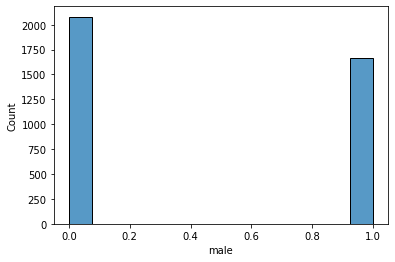

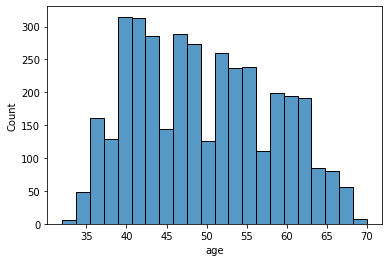

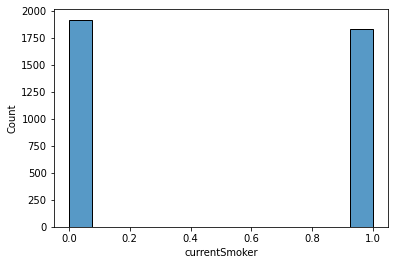

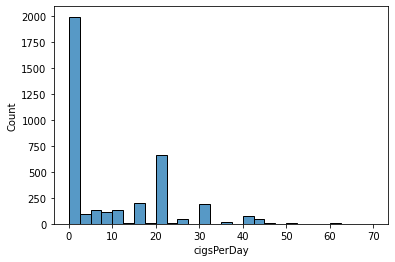

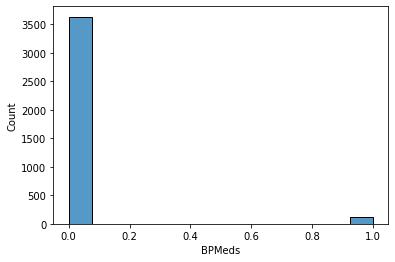

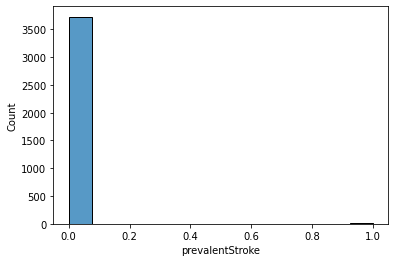

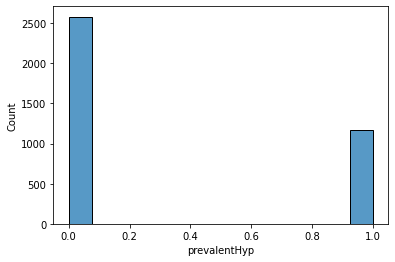

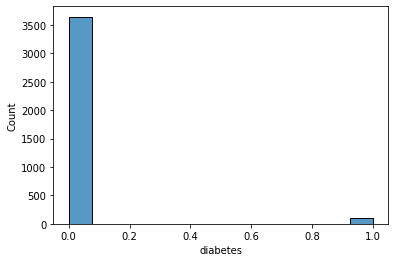

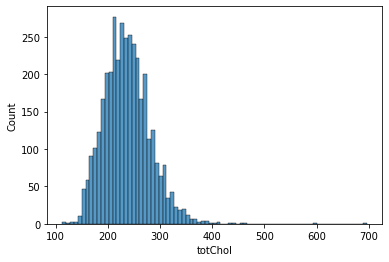

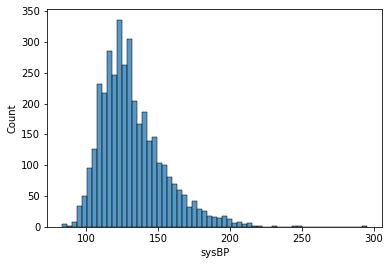

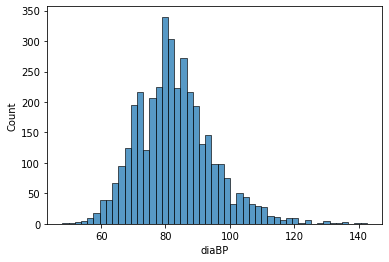

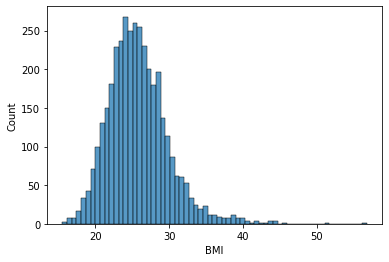

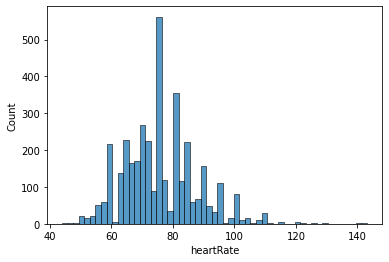

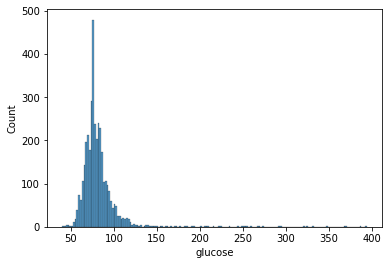

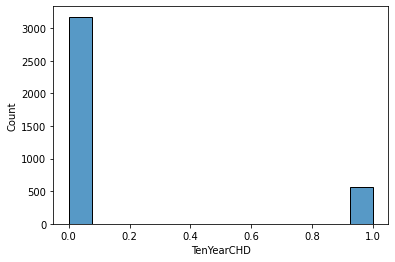

In [5]:
for column in df_heart_disease.columns:
    sns.histplot(x= column,data = df_heart_disease)
    plt.show()

### Train - Test Split

In [6]:
#np.random.seed(1000000000) # a seed makes the analysis reproducible
                     # so everyone will get the same results
ndata = len(df_heart_disease)
# Randomly choose 0.8n indices between 1 and n
idx_train = np.random.choice(range(ndata),int(0.8*ndata),replace=False)
# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test  = np.asarray(list(set(range(ndata)) - set(idx_train)))
train     = df_heart_disease.iloc[idx_train] # the training data set
test      = df_heart_disease.iloc[idx_test]  # the test data set
print(train.shape) # 
print(test.shape)  #  

(2999, 15)
(750, 15)


In [7]:
X_train = train.drop(columns='TenYearCHD')
Y_train = train['TenYearCHD'] 

X_test = test.drop(columns='TenYearCHD')
Y_test = test['TenYearCHD'] 

## Linear Discriminan Analysis

Logistic regression involves directly modeling $P(Y = k|X = x)$ using the logistic function. Therefore, with we model the conditional distribution of the response Y, given the predictor(s) X. Now, we can consider an alternative and less direct approach to estimating those probabilities. This new approach consists on modeling the distribution of the predictors X separately in each of the response classes (i.e. given Y), and then use Bayes’ theorem to flip these around into estimates for $P(Y = k|X = x)$. When these distributions are assumed to be normal, the model is very similar in form to logistic regression.

But, why do we need a method different than logistic regression?

There are multiple reasons:

* When the classes are well-separated, the parameter estimates for the logistic regression model are surprisingly unstable. Linear discriminant analysis does not suffer from this problem.

* If $n$ is small and the distribution of the predictors $X$ is approximately normal in each of the classes, the linear discriminant model is again more stable than the logistic regression model.

* Linear discriminant analysis is popular when there are more than two response classes.

### Bayes’ Theorem for Classification

Suppose that we wish to classify an observation into one of $k$ classes, where $k$ ≥ 2. Let $\pi_k$ represent the overall or prior probability that a randomly chosen observation comes from the $k^{th}$ class; this is the probability that a given observation is associated with the $k^{th}$ category of the response variable Y. Let $f_k(x) ≡ P(X = x|Y = k)$ denote the density function of $x$ for an observation that comes from the $k^{th}$ class. $f_k(x)$ is relatively large if there is a high probability that an observation in the $k^{th}$ class has $X ≈ x$, and $f_k(x)$ is small if it is very unlikely that an observation in the $k^{th}$ class has $X ≈ x$. Then, Bayes’ theorem states that: <center> $p_k(X)=P(Y = k|X = x) = \frac{\pi_kf_k(x)}{\sum_{i=1}^K \pi_if_i(x)}  $ </center>

According to the above, instead of directly computing $p_k(X)=P(Y = k|X = x)$, we can simply plug in estimates of $\pi_k$ and $f_k(X)$ into the previous formula. In general, estimating $\pi_k$ is easy, if we have a random sample of
$Y's$ from the population: just compute the fraction of the training observations that belong to the $k^{th}$ class. However, estimating $f_k(X)$ tends to be more challenging, unless some simple forms for these
densities are assumed.

The Bayes classifier, which classifies an observation to the class for which $p_k(X)$ is largest, has the lowest possible error rate out of all classifiers. Therefore, if we can find a way to estimate and correctly specify $f_k(X)$, then we can develop a classifier that approximates the Bayes classifier. Such an approach is the topic of the following sections.

### Linear Discriminant Analysis with one predictor

Assuming that the number of parameters (input variables) is 1, then we will classify an observation to the class
for which $p_k(x)$ is greatest. To do this, it is necessary to make an assumption about the form of $f_k(x)$ in order to estimate it. 

If we assume that $f_k(x)$ is normal or Gaussian. In the one-dimensional setting, the normal density takes the form: <center> $f_k(x)=\frac{1}{\sqrt{2\pi}\sigma_k}\text{exp}(\frac{1}{2\sigma^2_k}(x-\mu_k)^2)$ </center>

where $\mu_k$ and $\sigma_k$ are the mean and standard deviation of the parameter $x$ if the observation belong to the $k^{th}$ class. If we also assume that the variances for all of the $K$ classes are the same, $\sigma_1=\sigma_2=...=\sigma_K= \sigma$,then $p_k(x)$ can be expressed as follows: <center> $p_k(x)=\frac{\pi_k\frac{1}{\sqrt{2\pi}\sigma}\text{exp}(\frac{1}{2\sigma^2}(x-\mu_k)^2)}{\sum_{i=1}^K\pi_i\frac{1}{\sqrt{2\pi}\sigma}\text{exp}(\frac{1}{2\sigma^2}(x-\mu_i)^2)}$ </center>

The Bayes classifier involves assigning an observation $X = x$ to the class for which $p_k(X)$ is largest. Taking the log of the $p_k(X)$ defined above and rearranging the terms, it is not hard to show that this is equivalent to assigning the observation to the class for which <center> $\delta_k(x) = x*\frac{\mu_k}{σ^2}-\frac{\mu_k^2}{2σ^2}+log(π_k)$ </center>

 is the largest. If there were only two classes, then the Bayes classifier would assign an observation to class 1 if $2x(\mu_1-\mu_2) > \mu_1^2-\mu_2^2$, and to class 2 otherwise. In this case, the Bayes decision boundary corresponds to the point where <center> $x= \frac{\mu_1^2-\mu_2^2}{2(\mu_1-\mu_2)}=\frac{\mu_1+\mu_2}{2}$  </center>

Taking this into account, a Linear Discriminant Analysis model may look something like this: 

<figure>
<img src="/work/indu5012_case_15/fig/LDA_p=1.PNG" align="center"/> 

<figcaption align = "center"><b>Fig. 15.1 - Linear discriminant analysis example. The left panel shows the distribution used to create the value of the input variables for two different classes. The panel on the right shows the distribution of 20 observations sampled from each of the two classes. The dashed vertical line is the LDA decision boundary </b>.<i>Taken from (James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013))</i></figcaption>
</figure> 

Now, in order to approximate the Bayes classifier, the linear discriminant analysis (LDA) model uses estimates for $\pi_k$, $\mu_k$ and $\sigma$ in $p_k(x)$. The estimates used are the following: <center> $\hat\mu_k=\frac{1}{n_k}\sum_{i|y_i=k}x_i$ </center> <center> $\hat\sigma^2=\frac{1}{n-K}\sum_{k\in K}\sum_{i|y_i=k}(x_i-\hat\mu_k)^2$ </center> <center> $\hat\pi_k=\frac{n_k}{n}$ </center>

where $n_k$ are the number of observations that belong to the $k^{th}$ class. If there is prior knowledge about the probabilites of an observation being from a particular classs ($\pi_k$), then it can be used instead of its estimates. With these estimates, now the LDA classifier will assign an observation $X=x$ as the class for which <center> $\hat\delta_k(x) = x*\frac{\hat\mu_k}{\hatσ^2}-\frac{\hat\mu_k^2}{2\hatσ^2}+log(\hat\pi_k)$ </center>

 is the largest. The word "linear" in the LDA’s name comes from the fact that the discriminant functions $\hat\delta_k(x)$ are linear functions of x, as opposed to a more complex function of x.


### Linear Discriminant Analysis with multiple predictors

Extending the LDA to observations with multiple predictors $X=(X_1,X_2,\dots,X_m)$. In this case, the assumption that will be made is that $X$ is drawn from a multivariate Gaussian (or multivariate Normal) distribution with class-specific mean vectors and with a common covariance matrix. The multivariate Gaussian distribution assumes that each individual predictor follows a one-dimensional Normal distribution, with some correlation between each pair of predictors. A graphic example for the probability density function for a bivariate Gaussian distribution can be seen in the following figure:

<figure>
<img src="/work/indu5012_case_15/fig/Multivariate_Gaussian.PNG" align="center"/> 

<figcaption align = "center"><b>Fig. 15.2 - Probability density function for a bivariate Gaussian distribution. The panel on the left shows the case in which both variables are uncorrelated. the panel on the right shows the case in which both variables have a correlation coefficient of 0.7 </b>.<i>Taken from (James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013))</i></figcaption>

</figure>

To indicate that a $m$-dimensional random variable has a multivariate Gaussian distribution, we write $X\sim N(\mu,\Sigma)$, where $\mu$ is a vector with $m$ components and $\Sigma$ is a $m\times m$ covaraince matrix. Formally, the probability density function for a multivariate Gaussian is as follows: <center> $f(x)=\frac{1}{\sqrt{(2\pi)^m}|\Sigma|^{1/2}}\text{exp}(\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$ </center>

When there are more than 1 predictors, LDA assumes that predictors for observations that belong to the $k^{th}$ are drawn from a multivariate Gaussian $N(\mu_k,\Sigma)$, where $\mu_k$ is a class-specific means vector, and $\Sigma$ is the covariance matrix that is common for all of the classes. In similar fashion as in the single-predictor case, when plugging the probability density function of the multivariate Gaussian into the discrimamnt function, it is possible to show that the LDA will classify an observation $x$ as belonging to the class for which <center> $\delta_k(x) = x^T\Sigma^{-1}\mu_k-\frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k+log(\pi_k)$ </center>

 is the largest. Then, the LDA will compute the required estimates in order to determine the estimate for the discriminant function and then use it in order to classify observations as belonging to the class with the highest estimated discriminant function. An example of a LDA model classification when there are two predictors can be seen below: 

 <figure>
<img src="/work/indu5012_case_15/fig/2_LDA.PNG" align="center"/> 

<figcaption align = "center"><b>Fig. 15.3 - Graphic representation of a LDA classifier for a three-class classification problem.  </b>.<i>Taken from (James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013))</i></figcaption>

</figure>

### LDA Model Definition and fitting

In [8]:
#Defining model
lda = LinearDiscriminantAnalysis()

#Fitting model
lda_res = lda.fit(X_train, Y_train)

### LDA Model Validation

In [9]:
#Obtaining scores from the model
scores = cross_val_score(lda, X_train, Y_train, cv=10, scoring='accuracy')
print("Accuracy: ",scores.mean())

scores = cross_val_score(lda, X_train, Y_train, cv=10, scoring='recall')
print("Recall: ",scores.mean())

scores = cross_val_score(lda, X_train, Y_train, cv=10, scoring='roc_auc')
print("Roc_auc: ",scores.mean())

Accuracy:  0.8442876254180602
Recall:  0.09209065679925994
Roc_auc:  0.7222983999561692


### LDA Model Adjustement

In [10]:
parameters = {'shrinkage' : np.arange(0, 1, 0.01)}

#Linear Discriminant Analyisis model
lda = LinearDiscriminantAnalysis(solver='lsqr')

# Grid search 
grid = GridSearchCV(lda, parameters, cv=10, scoring='roc_auc')
grid.fit( X_train, Y_train)

# Best estimators
print("Best LDA shrinkage parameter: ",grid.best_estimator_)
print('Best LDA ROC_AUC score: %.3f' % np.abs(grid.best_score_))

Best LDA shrinkage parameter:  LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr')
Best LDA ROC_AUC score: 0.722


### LDA model Testing

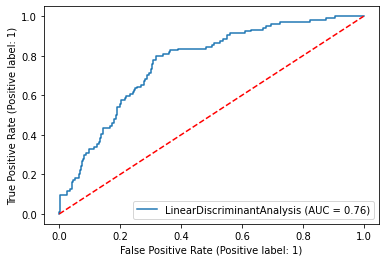

In [11]:
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train,Y_train)

RocCurveDisplay.from_estimator(lda, X_test, Y_test)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

## Quadratic Discriminant Analysis

As we discussed, LDA assumes that the observations within each class are drawn from a multivariate Gaussian distribution with a class-specific mean vector $\mu_k$ and a covariance matrix $\Sigma$ that is common to all K classes. However, Quadratic Discriminant Analysis (QDA) provides a different approach. QDA also assumes that observations within a specific class are drawn from a multivariate Gaussian distribution and uses estimates for the paramters to perform a prediction using Bayes' theorem. However, QDA assumes that each class has its own covariance matrix $\Sigma_k$. Therefore, an observation from the $k^{th}$ class is of the form $X\sim N(\mu_k,\Sigma_k)$ , where $\Sigma_k$ is a covariance matrix specific for the observations that come from the $k^{th}$ class. Under this assumption, the discriminant function is given as: <center> $\delta_k(x) = -\frac{1}{2}(x-\mu_k)^T\Sigma^{-1}_k(x-\mu_k)-\frac{1}{2}\log|\Sigma_k|+\log(\pi_k)$ </center> <center> $= -\frac{1}{2}x^T\Sigma^{-1}_kx + x^T\Sigma^{-1}_k\mu_k -\frac{1}{2}\mu_k^T\Sigma^{-1}_k\mu_k -\frac{1}{2}\log|\Sigma_k|+\log(\pi_k)$ </center>  

The QDA will then classify the observation x as coming from the class for which $\delta(x)$ is higher. When plugging estimates for $\mu_k$, $\Sigma_k$ and $\pi_k$ in $\delta(x)$, predictions can be done. This discriminant function is quadratic function in $x$ and that is why this method is called quadratic discriminant analysis. 

### Difference between LDA and QDA

As LDA assumes there is a common covariance matrix for all of the $K$ classes, the LDA model has less parameters to estimate in order to make a prediction. When there are $m$ predictors, then to estimate the covariance matrix there are $m(m+1)/2$ estimates to be calculated. Hence, QDA has to calculate $Km(m+1)/2$ values to estimate all of the $K$ covariance matrices. Then, the difference in the performance for LDA and QDA models lies in the bias-variance trade-off. As LDA has less estimates to calculate, it is less flexible than QDA, but LDA has a much lower variance. This can potentially lead to improved prediction performance. But there is a trade-off: if LDA’s assumption that the K classes share a common covariance matrix is badly off, then LDA can suffer from high bias. Roughly speaking, LDA tends to be a better bet than QDA if there are relatively few training observations and so reducing variance is crucial. In contrast, QDA is recommended if the training set is very large, so that the variance of the classifier is not a major concern, or if the assumption of a common covariance matrix for the K classes is clearly untrue.

 <figure>
<img src="/work/indu5012_case_15/fig/LDA_QDA.PNG" align="center"/> 

<figcaption align = "center"><b>Fig. 7.4 - Graphic representation of LDA and QDA classifiers for a two-class classification problem. The dotted black line represents the LDA's decision boundary, the green line represents the QDA's decision boundary and the purple dashed line represents the Bayes' decision boundary. On the left hand panel, both of the classes share the same covariance matrix and on the right hand panel both of the classes have different covariance matrices. </b>.<i>Taken from (James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013))</i></figcaption>

</figure>

### QDA Model Definition and fitting

In [12]:
#Defining model
qda = QuadraticDiscriminantAnalysis()

#Fitting model
qda_res = qda.fit(X_train, Y_train)

### QDA Model Validation

In [13]:
#Obtaining scores from the model
scores = cross_val_score(qda, X_train, Y_train, cv=10, scoring='accuracy')
print("Accuracy: ",scores.mean())

scores = cross_val_score(qda, X_train, Y_train, cv=10, scoring='recall')
print("Recall: ",scores.mean())

scores = cross_val_score(qda, X_train, Y_train, cv=10, scoring='roc_auc')
print("Roc_auc: ",scores.mean())

Accuracy:  0.82661872909699
Recall:  0.19014801110083254
Roc_auc:  0.7065409971338713


### QDA Model Adjustement

In [14]:
#Parameters list
parameters = {
    'reg_param': np.arange(0, 1, 0.01), 
                   }

#Quadratic Discriminant Analyisis model
qda = QuadraticDiscriminantAnalysis()

grid = GridSearchCV(qda, parameters, cv=10, scoring='roc_auc')
grid.fit(X_train, Y_train)

# Best estimators
print("Best QDA parameters: ",grid.best_estimator_)
print('Best QDA ROC_AUC score: %.3f' % np.abs(grid.best_score_))

Best QDA parameters:  QuadraticDiscriminantAnalysis(reg_param=0.05)
Best QDA ROC_AUC score: 0.709


### QDA model Testing

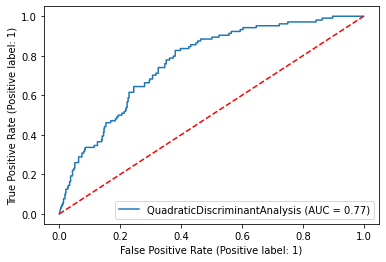

In [15]:
qda = QuadraticDiscriminantAnalysis(reg_param = 0.22)
qda_res = qda.fit(X_train, Y_train)

RocCurveDisplay.from_estimator(qda, X_test, Y_test)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

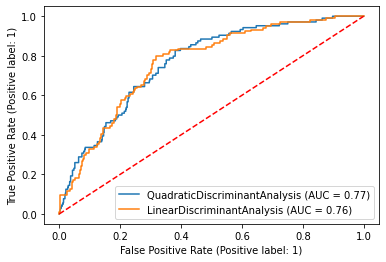

In [18]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(qda, X_test, Y_test, ax=ax)
RocCurveDisplay.from_estimator(lda, X_test, Y_test,ax=ax)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")

fig.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=96262903-a28f-4719-a328-dc59e3cfa77f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>